This is a basic notebook detailing how to set up and run an Fp-statistic analysis using fastfp on some input dataset. You'll need to supply your own data file and noise dictionary. The only major difference between this notebook and an Fp-statistic analysis set up using enterprise is that here we use JAX to significantly speed up the computation.

In [ ]:
import pickle, json, time

import numpy as np
import scipy.stats as ss

import jax

from fastfp.fastfp import FastFp
from fastfp.utils import initialize_pta, get_mats

import matplotlib.pyplot as plt

In [2]:
# load a pickle file with your enterprise Pulsar objects
# and the corresponding white/red- noise dictionary
with open('...', 'rb') as f:
    psrs = pickle.load(f)

with open('...', 'r') as f:
    noise = json.load(f)

# if you're using a model with a common red-noise process (such as a GWB)
# add those parameters to the noise dictionary here
noise['gw_gamma'] = 13/3
noise['gw_log10_A'] = np.log10(2e-15)

In [ ]:
# initialize the PTA object and precompute a bunch of
# fixed matrix products that go into the Fp-statistic calculation
pta = initialize_pta(psrs, noise, inc_cp=True, gwb_comps=30)

t_start = time.perf_counter()
Nvecs, Ts, sigmas = get_mats(pta, noise)
t_end = time.perf_counter()
print('Precompute matrix wall time: {0:.4f} s'.format(t_end - t_start))

Precompute matrix wall time: 25.2763 s


In [ ]:
# initialize Fp-stat class
Fp_obj = FastFp(psrs, pta)
# define the range of GW frequencies
freqs = np.linspace(2e-9, 3e-7, 200)

# the Fp-statistic calculation is jit-compiled and batched
# over the array of frequencies, turning it into a single
# calculation instead of a for loop
# (for more info, see documentation for jax.vmap)
t_start = time.perf_counter()
fn = jax.vmap(Fp_obj.calculate_Fp, in_axes=(0, None, None, None))
fps = fn(freqs, Nvecs, Ts, sigmas)
t_end = time.perf_counter()
print('Fp-statistic wall time: {0:.4f} s'.format(t_end - t_start))

Fp-statistic wall time: 33.5623 s


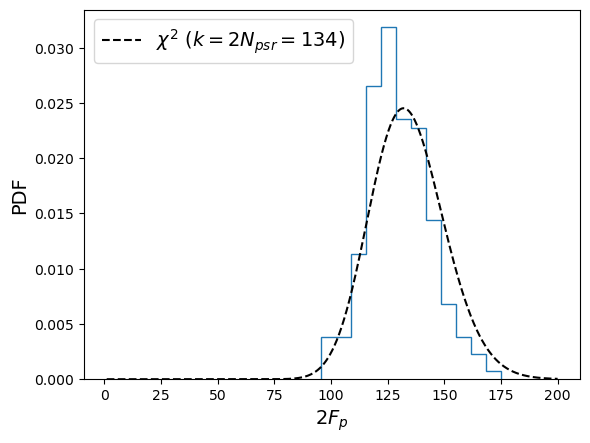

In [7]:
# plot histogram of Fp values, compare to expected
# chi-squared distribution for data with no CWs
x = np.linspace(1, 200, 2000)

fig, ax = plt.subplots()
ax.hist(2*fps, density=True, histtype='step', bins=12);
ax.plot(x, ss.chi2.pdf(x, df=2*67), c='black', ls='--', label='$\chi^{2}$ ($k=2N_{psr}=134$)');

ax.set_xlabel('$2F_{p}$', size=14);
ax.set_ylabel('PDF', size=14);
plt.legend(fontsize=14);

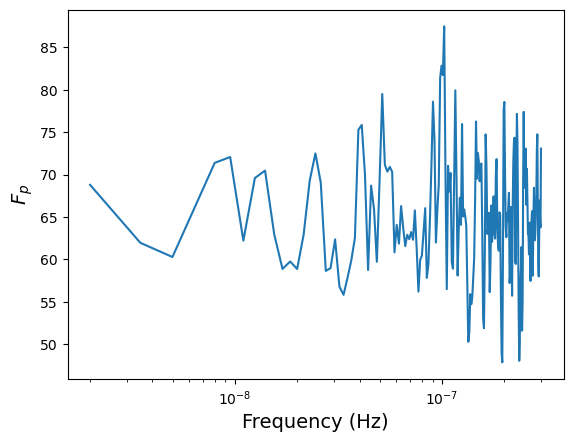

In [8]:
# plot Fp values as a function of frequency
fig, ax = plt.subplots()
ax.plot(freqs, fps);
ax.set_xscale('log');
ax.set_xlabel('Frequency (Hz)', size=14);
ax.set_ylabel('$F_{p}$', size=14);